In [1]:
import sys
import os

from pathlib import Path
p = Path(os.getcwd()).parents[1]
sys.path.append(p.__str__())

from tyxe_runfiles import train, generate, eval
#from runfiles import train, generate, eval
from modules.config import read_config
import modules.plots as plots
from modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import pyro
import pyro.poutine as poutine
import json

sns.set_style("darkgrid")
sns.set_context("paper")

In [2]:
BASE_DIR = "../../experiments/sin-models-large"

In [3]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

profiles = ["1layer-large-s1", "2layer-large-s1", "3layer-large-s1"]
#profiles = ["1layer-large-s02", "2layer-large-s02", "3layer-large-s02"]

names = [configs[p]["NAME"] for p in profiles]

In [4]:
configs.keys()

KeysView(<configparser.ConfigParser object at 0x7f6654409ee0>)

In [5]:
train_stats = {}
for p in profiles:
    name = configs[p]["NAME"]
    with open(f"{BASE_DIR}/results/{name}/train_stats.json", "r") as f:
        train_stats[name] = json.load(f)

results = {}
for p in profiles:
    name = configs[p]["NAME"]
    with open(f"{BASE_DIR}/results/{name}/results.json", "r") as f:
        results[name] = json.load(f)

# Load posterior samples
posterior_samples = {}
for p in profiles:
    name = configs[p]["NAME"]
    # Load posterior samples
    train = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/predictions_train.npy")
    test = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/predictions_test.npy")
    test_in_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/predictions_in_domain.npy")
    test_out_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/predictions_out_domain.npy")

    posterior_samples[name] = {
        "train": train,
        "test": test,
        "test_in_domain": test_in_domain,
        "test_out_domain": test_out_domain
    }

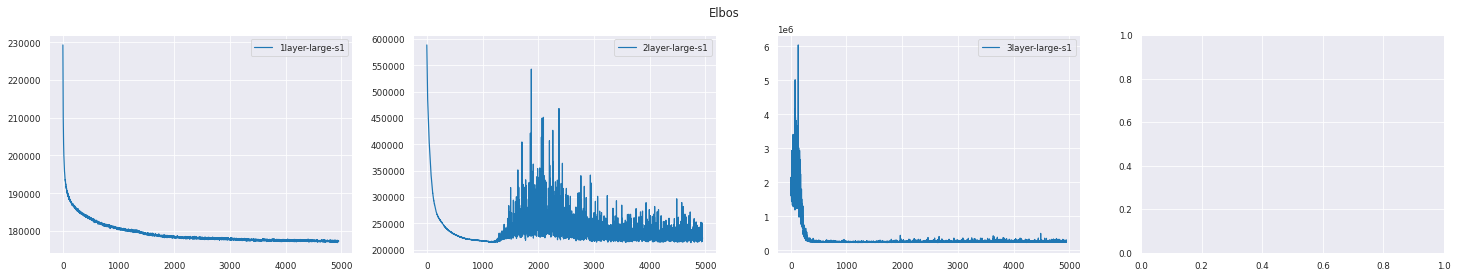

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(25, 4))
fig.suptitle("Elbos")
ax = ax.flatten()
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    elbos = train_stats[name]["elbos"][50:]
    ax[i].plot(elbos, label=name)
    ax[i].legend()
plt.show()

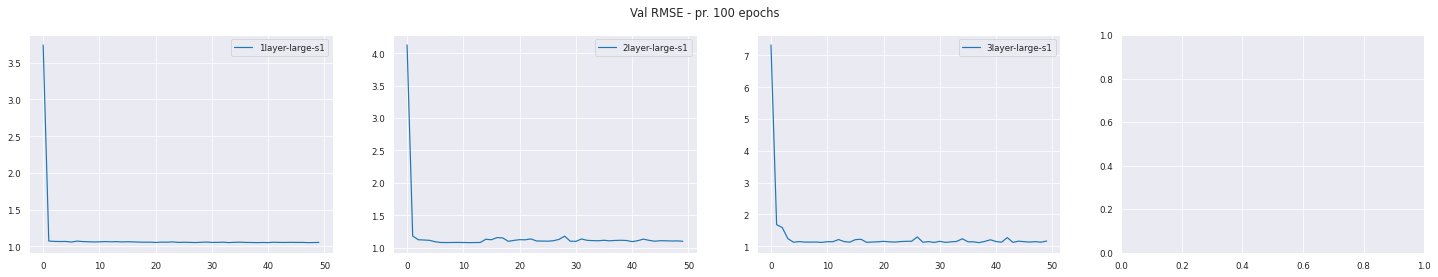

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(25, 4))
fig.suptitle("Val RMSE - pr. 100 epochs")
ax = ax.flatten()
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    rmse = train_stats[name]["rmse_epoch"]
    ax[i].plot(rmse, label=name)
    ax[i].legend()
plt.show()

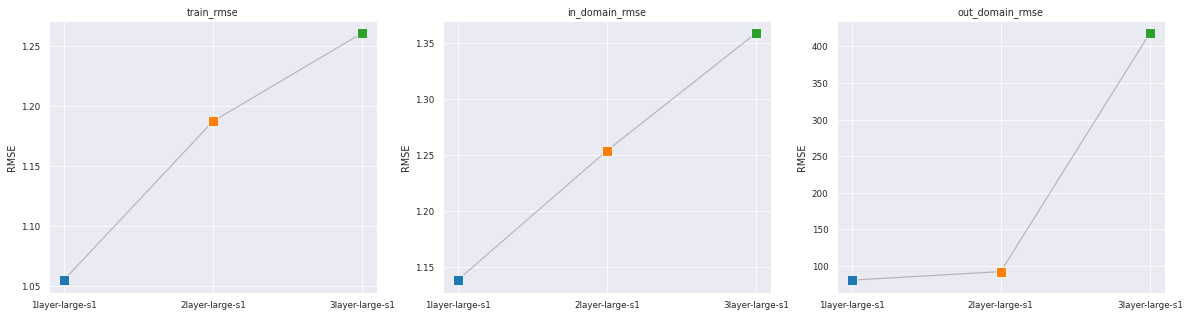

In [8]:
train_rmse = [results[k]["train_error"]["rmse"] for k in names]
in_domain_rmse = [results[k]["in_domain_error"]["rmse"] for k in names]
out_domain_rmse = [results[k]["out_domain_error"]["rmse"] for k in names]

metrics = [("train_rmse", train_rmse), ("in_domain_rmse", in_domain_rmse), ("out_domain_rmse", out_domain_rmse)]

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

fig, ax = plt.subplots(1,3, figsize=(20,5))
ax = ax.flatten()
for i, (n, m) in enumerate(metrics):
    sns.scatterplot(
    x=names, y=m, marker="s", s=100,
    ax=ax[i], c=colors, alpha=1.0, zorder=10)
    sns.lineplot(
    x=names, y=m, ax=ax[i], color="gray", alpha=0.5)
    ax[i].set_title(n)
    ax[i].set_ylabel("RMSE")

plt.show()

In [9]:
name1 = configs[profiles[1]]["NAME"]
data_samples = {
    "train_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_x.npy"),
    "test_in_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_x.npy"),
    "test_out_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_x.npy"),
    #"test_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_x.npy"),
    "train_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_dist_samples.npy"),
    "test_in_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_dist_samples.npy"),
    "test_out_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_dist_samples.npy"),
    #"test_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_dist_samples.npy"),
}


In [10]:
print(data_samples["train_x"].shape)
print(data_samples["train_dist_samples"].shape)
print(posterior_samples[name1]["train"].shape)

(100, 10)
(1000, 100)
(1000, 100)


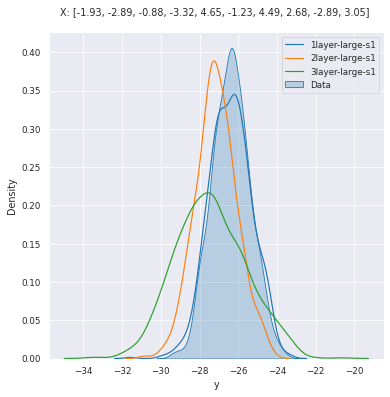

In [11]:

# Plot posterior samples
labels = [configs[p]["NAME"] for p in profiles]
x_samp = data_samples["train_x"][1]
train_samp = data_samples["train_dist_samples"][:, 1]
pred_train_samples = [posterior_samples[p]["train"][:, 1] for p in profiles]
plots.plot_comparisons(pred_train_samples, train_samp, labels=labels, figsize=(6,6), x_sample=x_samp, title="Posterior samples - Train", save_path=f"{BASE_DIR}/results/posterior_comparison.png")

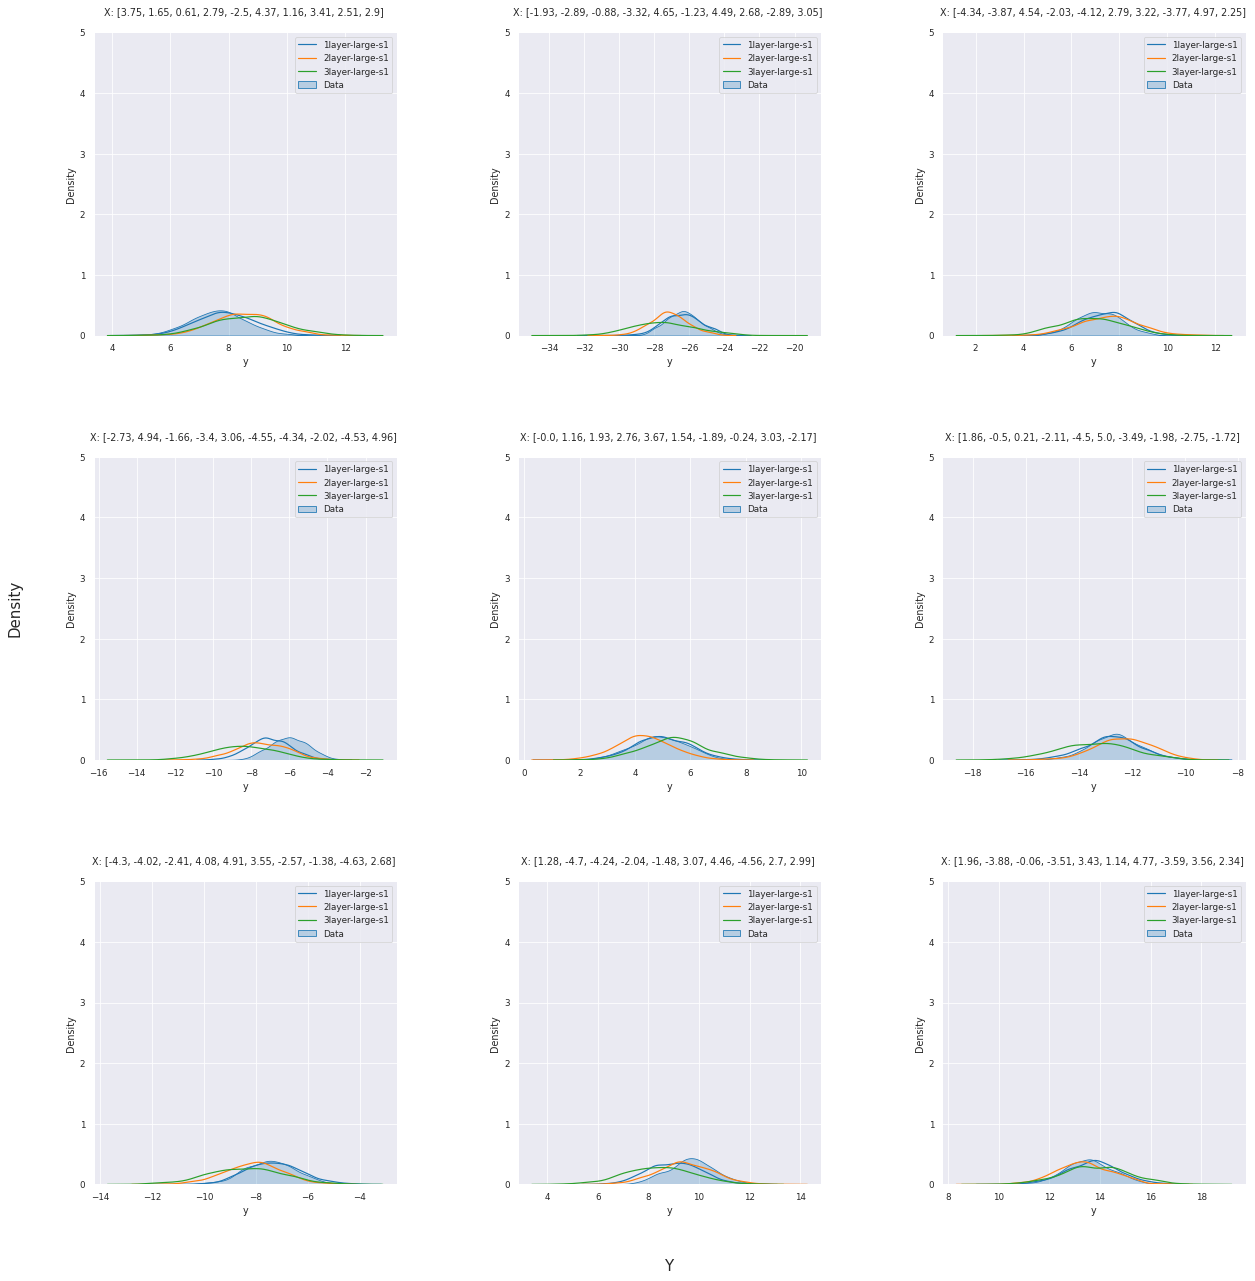

In [12]:
sns.set_style("darkgrid")
sns.set_context("paper")

fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.flatten()
fig.tight_layout()
#fig.suptitle(title, fontsize=15)
fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.4, wspace=0.4)
fig.text(0.5, 0.04, 'Y', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=15)

for i, ax in enumerate(axs):
    labels = [configs[p]["NAME"] for p in profiles]
    x_samp = data_samples["train_x"][i]
    train_samp = data_samples["train_dist_samples"][:, i]
    pred_train_samples = [posterior_samples[p]["train"][:, i] for p in profiles]
    plots.plot_comparisons(pred_train_samples, train_samp, labels=labels, x_sample=x_samp, ax=ax)   
    ax.set_ylim([0, 5])

plt.show()